# **Image Classification with Deployment Project: Animal Images Classification**
By Haris Yafie

ID Dicoding: harisyafie

Email: yafie345@gmail.com

# **Introduction**
We are going through to make a classifier for animal images using a Transfer Learning method with the help of TensorFlow and Keras. We also going to saved the model in TFLite so it can be use for a mobile application. Happy exploring!

# **Library**
## Import Libraries and Packages
The main library for this project are TensorFlow and its package Keras. So, the first thing you need is to import TensorFlow (make sure you already install the TensorFlow) and Keras will right away imported too. Then to create a new data from our dataset we use ImageDataGenerator from Keras for our image augmentation step.

In [1]:
# Library for data preprocessing
import os
import zipfile
import cv2
import shutil
from google.colab import files
from PIL import Image

# Library for machine learning modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pathlib

# **Data Preparation**
## Download and Extract The Dataset
Next, we are going to download the dataset using gdown command from the link that have been provided by me. The dataset source is Kaggle with the name Animals10.

Download the dataset

In [2]:
!gdown 1KMvP1mgQQVDIf3hrP8_d1-4R_wcHQqx0

Downloading...
From: https://drive.google.com/uc?id=1KMvP1mgQQVDIf3hrP8_d1-4R_wcHQqx0
To: /content/animals10.zip
100% 614M/614M [00:12<00:00, 50.7MB/s]


Extract the zip file

In [3]:
local_file = '/content/animals10.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Resolution Check
Below is the code to check the resolution of an image dataset. We want to make sure, whether the dataset contains resolution differences between all images or not.

Functions to get image resolution

In [5]:
def get_image_resolution(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        height, width, _ = image.shape
        return width, height
    else:
        return None

def check_dataset_resolution(dataset_path):
    resolutions = set()

    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            image_path = os.path.join(dataset_path, filename)
            resolution = get_image_resolution(image_path)
            if resolution is not None:
                resolutions.add(resolution)

    return resolutions

Take one folder for the example

In [6]:
dataset_path = '/content/raw-img/cane'

In [7]:
unique_resolutions = check_dataset_resolution(dataset_path)

# Print unique resolutions
print("Unique Resolutions:")
for resolution in unique_resolutions:
    print(resolution)

Unique Resolutions:
(300, 270)
(300, 279)
(181, 300)
(300, 117)
(300, 135)
(238, 300)
(249, 300)
(160, 240)
(300, 229)
(300, 238)
(200, 300)
(222, 300)
(211, 300)
(300, 247)
(258, 241)
(300, 256)
(300, 265)
(279, 300)
(300, 121)
(241, 300)
(230, 300)
(300, 224)
(246, 253)
(300, 233)
(300, 242)
(203, 300)
(300, 251)
(192, 300)
(300, 260)
(231, 300)
(250, 250)
(300, 107)
(299, 300)
(300, 210)
(219, 285)
(300, 219)
(261, 300)
(300, 228)
(300, 237)
(241, 160)
(300, 246)
(214, 300)
(291, 300)
(300, 205)
(300, 214)
(300, 223)
(300, 232)
(300, 241)
(244, 300)
(233, 300)
(195, 300)
(206, 300)
(300, 191)
(300, 200)
(263, 300)
(274, 300)
(300, 209)
(157, 300)
(168, 300)
(300, 218)
(300, 227)
(225, 300)
(236, 300)
(264, 300)
(198, 300)
(176, 300)
(187, 300)
(300, 186)
(300, 195)
(300, 204)
(255, 300)
(300, 213)
(300, 222)
(294, 300)
(283, 300)
(217, 300)
(256, 300)
(245, 300)
(300, 172)
(179, 300)
(288, 216)
(300, 181)
(300, 190)
(300, 199)
(300, 208)
(286, 300)
(300, 167)
(239, 300)
(228, 300)
(

From the function we runned, we can conclude that the dataset contains a resolution differences between all the images. Therefore, we should have to do a data preprocessing process later.

We set the main directory of our project to load the dataset

In [8]:
BASE_DIR = '/content/raw-img'

## Print The Images Example
Before we going to do the data preprocessing, we want to know examples of images for each class available in the dataset.

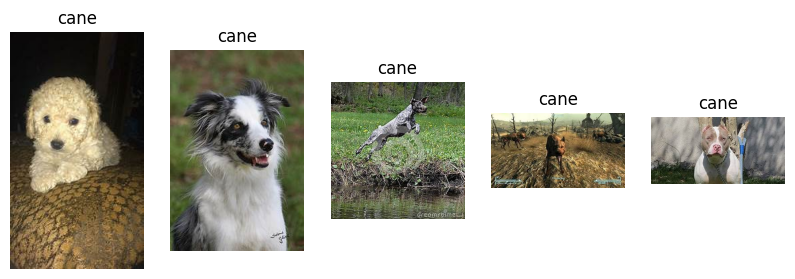

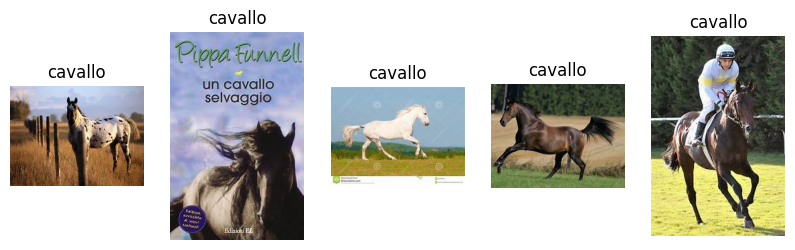

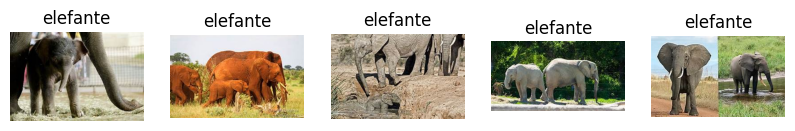

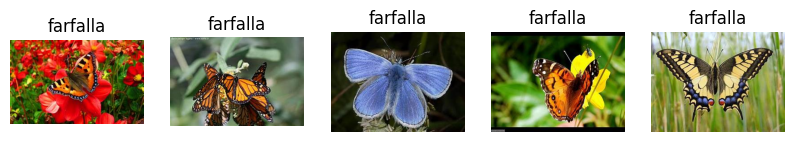

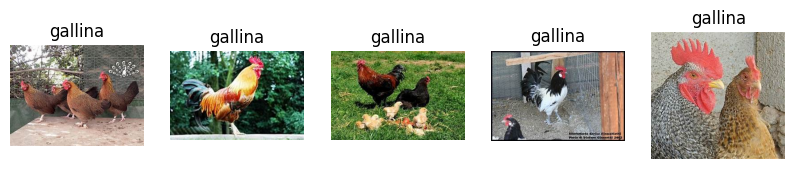

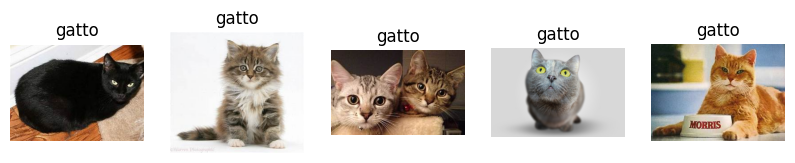

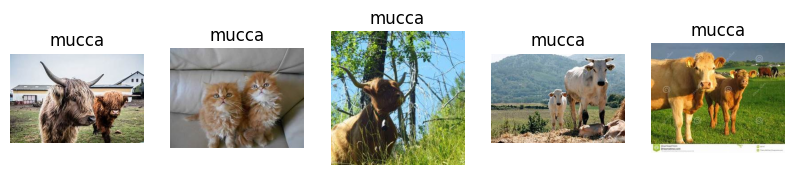

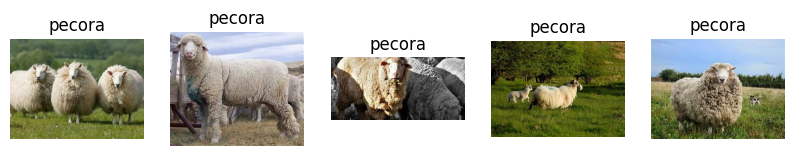

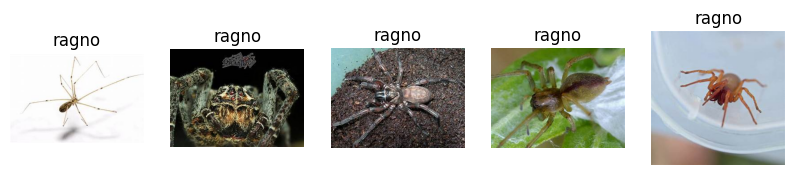

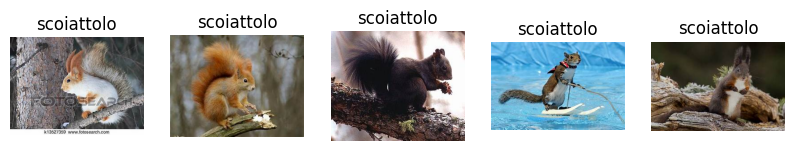

In [9]:
class_folders = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

for class_name in class_folders:
    class_path = os.path.join(BASE_DIR, class_name)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)[:5]]  # Get 5 images for each class

    plt.figure(figsize=(10, 10))

    for i, img_path in enumerate(class_images):
        plt.subplot(1, 5, i + 1)  # Create subplots for 5 images
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')  # Remove axes for cleaner display
        plt.title(class_name)

    plt.show()  # Display the images

# **Data Preprocessing**

Before we process the dataset by dividing it into training and validation, we must resize our images to the same resolution. We will use an image resolution of 224x224 because most forms of transfer learning are 224x224.

In [10]:
import os
from PIL import Image

def resize_images_in_folder(folder_path, target_size=(224, 224), output_folder='resized_data'):
    os.makedirs(output_folder, exist_ok=True)

    for class_name in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_name)
        output_class_folder_path = os.path.join(output_folder, class_name)
        os.makedirs(output_class_folder_path, exist_ok=True)

        for filename in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, filename)
            output_image_path = os.path.join(output_class_folder_path, filename)

            # Resize the image
            resized_image = resize_image(image_path, target_size)

            # Save the resized image to the output folder
            resized_image.save(output_image_path)

def resize_image(image_path, target_size):
    image = Image.open(image_path)
    resized_image = image.resize(target_size)
    return resized_image

# Define the paths
output_folder = '/content/resized'

# Set the target size for resizing
target_size = (224, 224)

In [11]:
# Resize images in the data folder
resize_images_in_folder(BASE_DIR, target_size, output_folder)

We set a new directory with resized images for our dataset

In [12]:
NEW_DIR = '/content/resized'

After we resize our images, we are going to split the dataset into training and validation. In the Training and Validation datasets, several features are used for image augmentation such as rescale, shear range, zoom range, and flipping horizontally. Then we split the dataset into 80:20 where the training is 80% and validation is 20%.

## Training Dataset

In [13]:
training_datagen = ImageDataGenerator(rescale=1. / 255,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      validation_split=0.2)

training_generator = training_datagen.flow_from_directory(NEW_DIR,
                                                          target_size=(224, 224),
                                                          batch_size=32,
                                                          class_mode='categorical',
                                                          shuffle=True,
                                                          seed=42,
                                                          subset='training')

Found 20947 images belonging to 10 classes.


To print out the class label and as you can see there are 10 classes.

In [14]:
# Get the class labels
training_class_labels = list(training_generator.class_indices.keys())
training_class_labels

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

## Validation Dataset

In [15]:
validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(NEW_DIR,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode='categorical',
                                                             shuffle=False,
                                                             seed=42,
                                                             subset='validation')

Found 5232 images belonging to 10 classes.


Same as the training dataset, validation dataset also has 10 classes.

In [16]:
# Get the class labels
validation_class_labels = list(validation_generator.class_indices.keys())
validation_class_labels

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

# **Machine Learning Modelling**
After data preprocessing, next up modelling our machine learning model. We are going to use MobileNetV2 as our transfer learning model as the base model then we are going to add another layers later.

## Base Model

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization

# Load MobileNetV2 model pre-trained on ImageNet data (include_top=False to exclude the original classification layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

The summary of base model

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## Modelling
After we load our base model, we are going to add new layers then we compile the model.

In [19]:
# Add a new classification head layers
model = models.Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(rate=0.2, seed=42))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.2, seed=42))
model.add(layers.Dense(training_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

The summary of our model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1280)        5120      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 256)         2949376   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 256)         0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 256)               0         
 GlobalAveragePooling2D)                                

## Callback
Implementing callback for our model if the training accuracy and validation accuracy above 95%, the training will stop

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95 and logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy in both validation and training, so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## Train the model
Let's train our model

In [22]:
# Train the model
history = model.fit(
    training_generator,
    steps_per_epoch=training_generator.samples // 32,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=callbacks
)

Epoch 1/15
654/654 [==============================] - 282s 417ms/step - loss: 0.3975 - accuracy: 0.8894 - val_loss: 0.2337 - val_accuracy: 0.9327
Epoch 2/15
654/654 [==============================] - 272s 415ms/step - loss: 0.2478 - accuracy: 0.9272 - val_loss: 0.1781 - val_accuracy: 0.9500
Epoch 3/15
654/654 [==============================] - 271s 414ms/step - loss: 0.2130 - accuracy: 0.9349 - val_loss: 0.1745 - val_accuracy: 0.9507
Epoch 4/15
654/654 [==============================] - 271s 414ms/step - loss: 0.1897 - accuracy: 0.9403 - val_loss: 0.1983 - val_accuracy: 0.9498
Epoch 5/15
654/654 [==============================] - 275s 420ms/step - loss: 0.1720 - accuracy: 0.9455 - val_loss: 0.1795 - val_accuracy: 0.9507
Epoch 6/15
654/654 [==============================] - 270s 412ms/step - loss: 0.1649 - accuracy: 0.9498 - val_loss: 0.1854 - val_accuracy: 0.9546
Epoch 7/15
654/654 [==============================] - 271s 415ms/step - loss: 0.1479 - accuracy: 0.9541 - val_loss: 0.2046 -

# **Model Evaluation**

Model evaluation from the results of the training process is shown by creating accuracy plots and loss plots for training and validation.

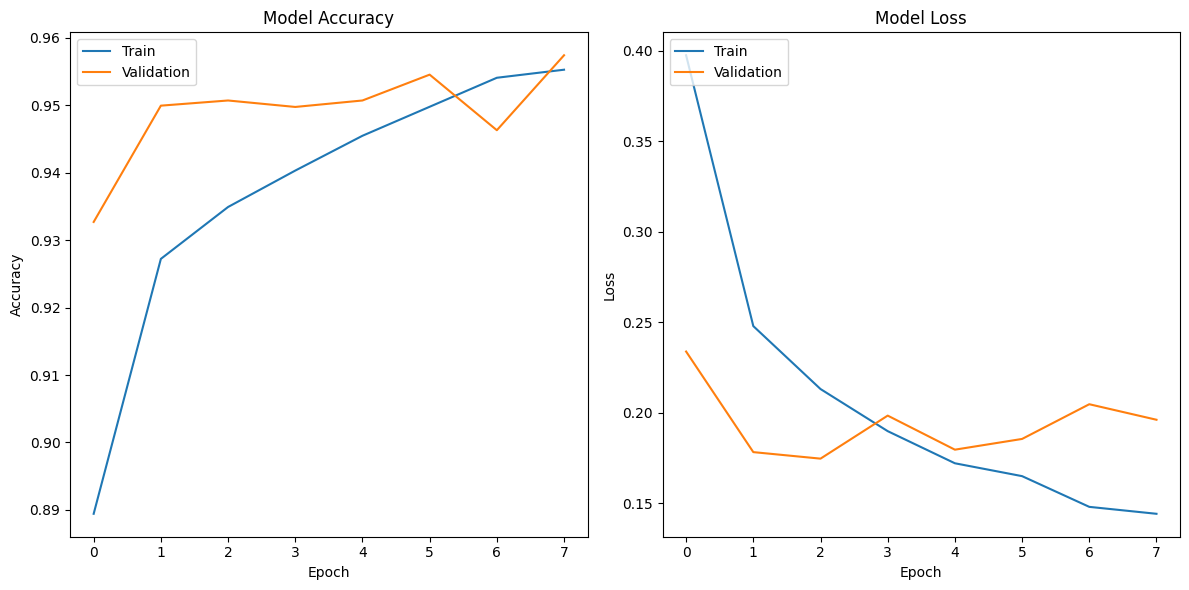

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot Accuracy on the first subplot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot Loss on the second subplot
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

plt.show()

# Saved Model to TFLite Format
Then after we train our model, let's save it and convert the saved model into TFLite format.

In [25]:
# Saves the model in SavedModel format
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [26]:
# Convert SavedModel become animale.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('animale.tflite')
tflite_model_file.write_bytes(tflite_model)

20949168

# **Conclusion**
We successfully implement transfer learning with MobileNetV2 into animal image classification dataset. We achieved 95% accuracy. We also successfuly convert our saved model into TFLite.